In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_saw')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_saw')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 257.0

ng = 8

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   3 /)

data wgt
     &     /.55, .55, .85,
     &     .85, .85,
     &     0, .3, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'saw75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

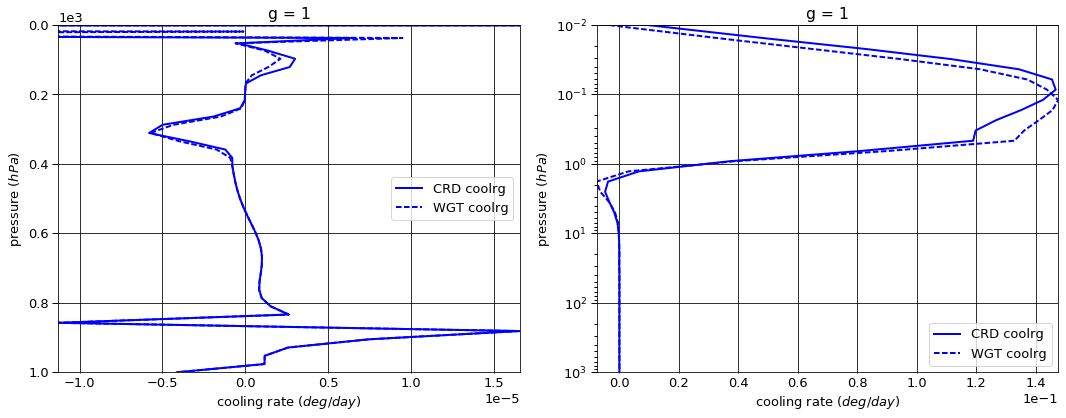

# Figure: cooling rate g-group 2

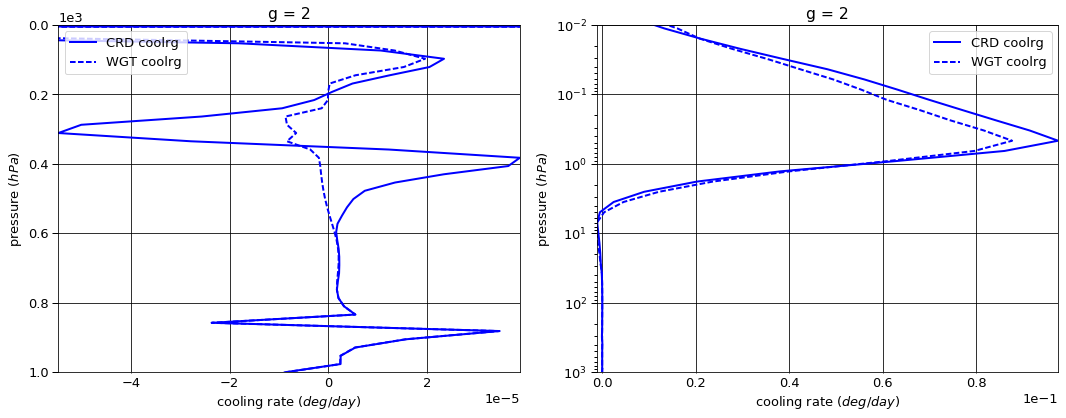

# Figure: cooling rate g-group 3

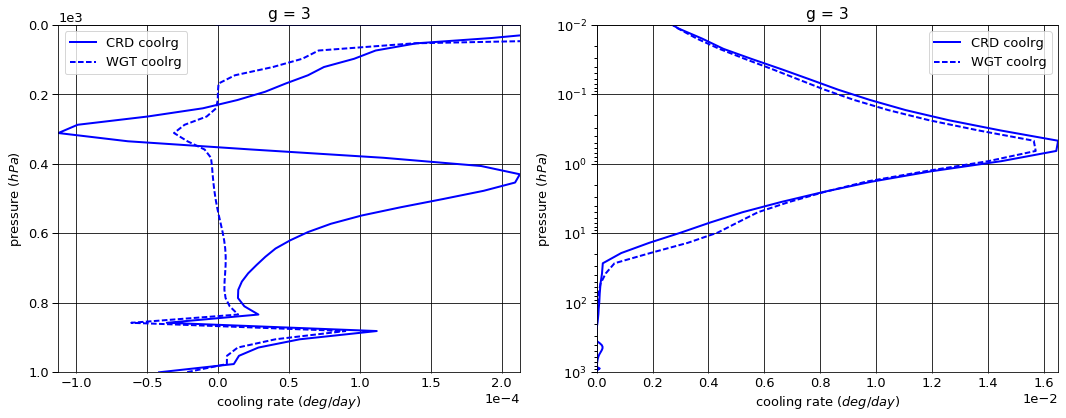

# Figure: cooling rate g-group 4

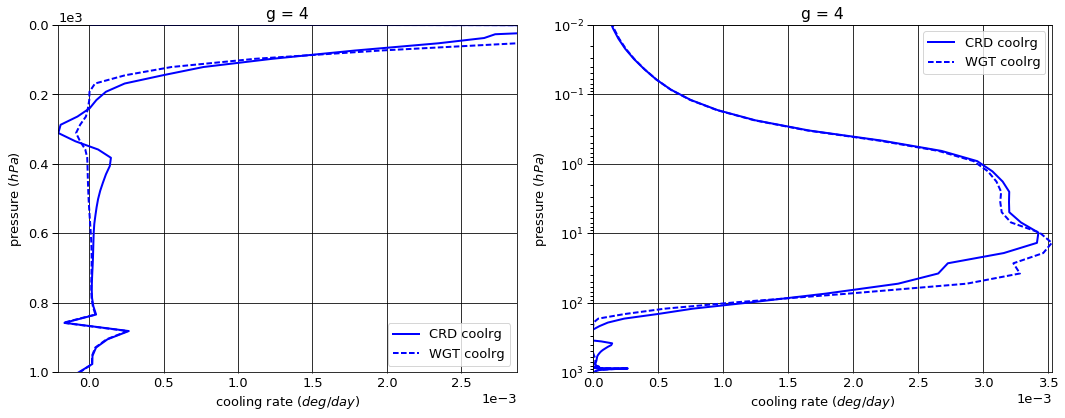

# Figure: cooling rate g-group 5

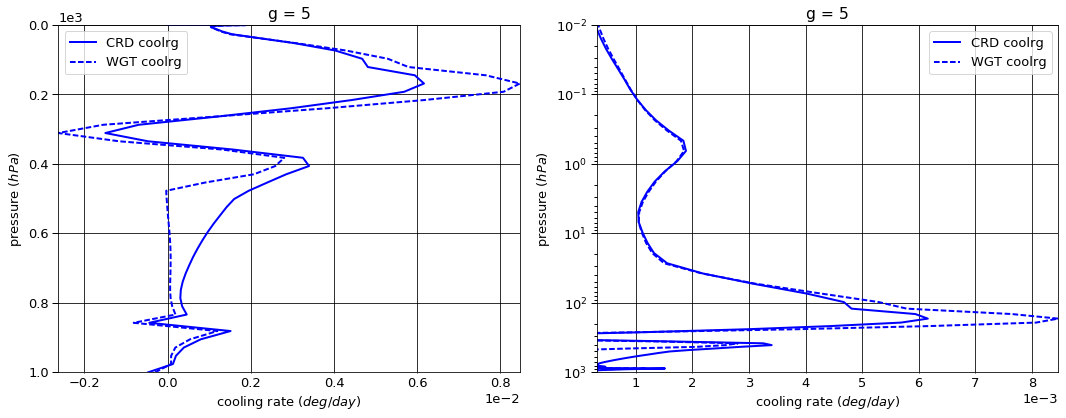

# Figure: cooling rate g-group 6

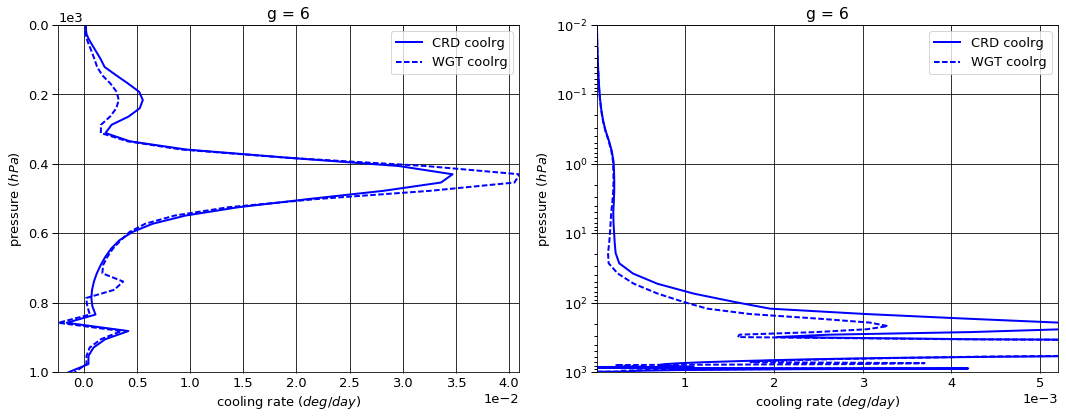

# Figure: cooling rate g-group 7

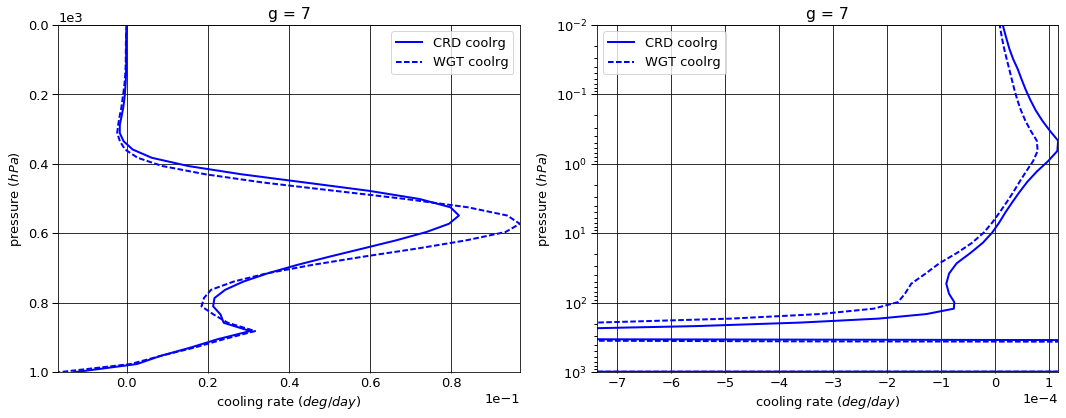

# Figure: cooling rate g-group 8

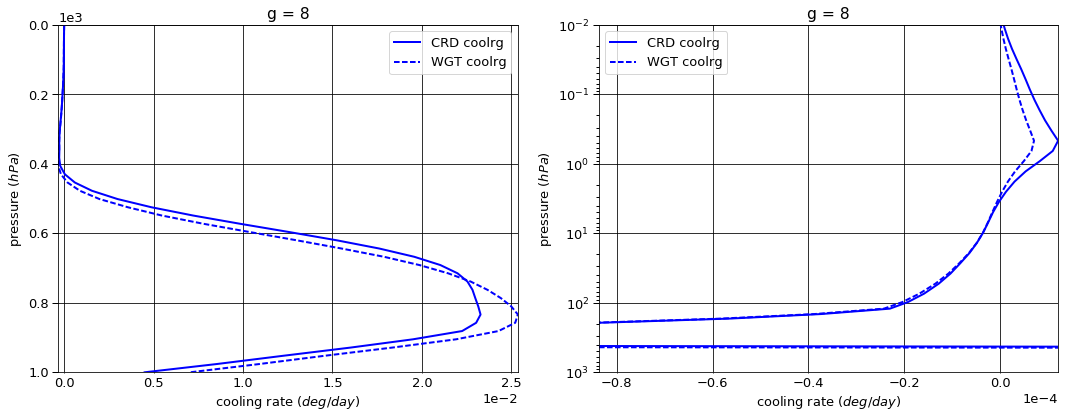

# Figure: cooling rate g-group total

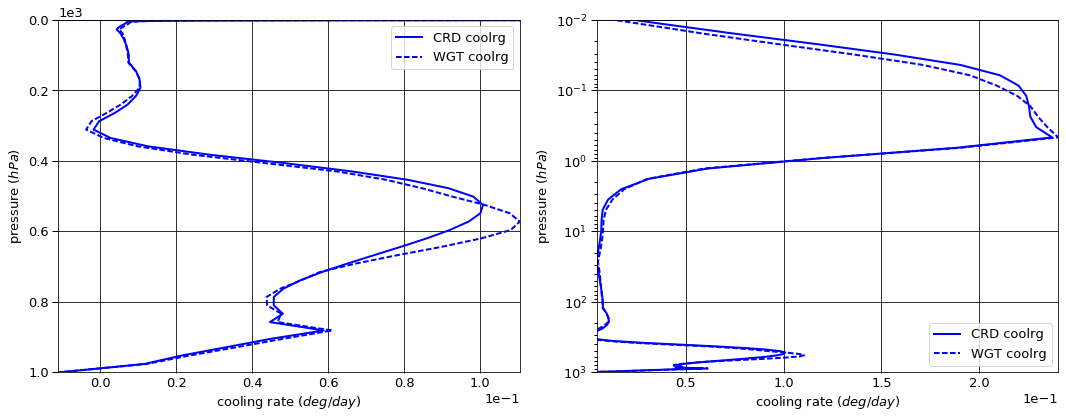

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009644  0.000000 -0.009644
  1013.0   76    -0.012192  0.012206  0.000014
2 0.0      1     -0.012730  0.000000 -0.012730
  1013.0   76    -0.025697  0.025727  0.000030
3 0.0      1     -0.016094  0.000000 -0.016094
  1013.0   76    -0.066001  0.066161  0.000160
4 0.0      1     -0.035431  0.000000 -0.035431
  1013.0   76    -0.189890  0.190138  0.000248
5 0.0      1     -0.198886  0.000000 -0.198886
  1013.0   76    -0.881995  0.883871  0.001876
6 0.0      1     -0.764623  0.000000 -0.764623
  1013.0   76    -2.596690  2.601685  0.004996
7 0.0      1     -2.729049  0.000000 -2.729049
  1013.0   76    -5.071819  5.145567  0.073749
8 0.0      1     -1.110461  0.000000 -1.110461
  1013.0   76    -1.337157  1.223026 -0.114131


WGT


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.010067  0.000000 -0.010067
  1013.0   76    -0.012192  0.012206  0.000014
2 0.0      1     -0.012505  0.000000 -0.012505
  1013.0   76    -0.025697  0.025727  0.000029
3 0.0      1     -0.014188  0.000000 -0.014188
  1013.0   76    -0.066001  0.066077  0.000076
4 0.0      1     -0.034265  0.000000 -0.034265
  1013.0   76    -0.189890  0.190109  0.000218
5 0.0      1     -0.173855  0.000000 -0.173855
  1013.0   76    -0.881995  0.883007  0.001013
6 0.0      1     -0.780667  0.000000 -0.780667
  1013.0   76    -2.596690  2.599677  0.002987
7 0.0      1     -2.810308  0.000000 -2.810308
  1013.0   76    -5.071819  5.161390  0.089571
8 0.0      1     -1.140550  0.000000 -1.140550
  1013.0   76    -1.337157  1.207049 -0.130108


WGT - CRD


flug          fldg         fnetg
g pressure level                                      
1 0.0      1     -0.000423  0.000000e+00 -4.228322e-04
  1013.0   76     0.000000  0.000000e+00  0.000000e+00
2 0.0      1      0.000225  0.000000e+00  2.248620e-04
  1013.0   76     0.000000 -5.970000e-07 -5.965890e-07
3 0.0      1      0.001906  0.000000e+00  1.906385e-03
  1013.0   76     0.000000 -8.381600e-05 -8.381624e-05
4 0.0      1      0.001166  0.000000e+00  1.166084e-03
  1013.0   76     0.000000 -2.950000e-05 -2.949632e-05
5 0.0      1      0.025032  0.000000e+00  2.503170e-02
  1013.0   76     0.000000 -8.636000e-04 -8.635967e-04
6 0.0      1     -0.016043  0.000000e+00 -1.604338e-02
  1013.0   76     0.000000 -2.008800e-03 -2.008779e-03
7 0.0      1     -0.081259  0.000000e+00 -8.125910e-02
  1013.0   76     0.000000  1.582270e-02  1.582268e-02
8 0.0      1     -0.030089  0.000000e+00 -3.008870e-02
  1013.0   76     0.000000 -1.597740e-02 -1.597748e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.799575e-01
  1001.112500 75    -4.126409e-06
2 0.000312    1     -1.933238e-02
  1001.112500 75    -8.806777e-06
3 0.000312    1     -9.226541e-07
  1001.112500 75    -4.148073e-05
4 0.000312    1      8.341122e-06
  1001.112500 75    -7.121327e-05
5 0.000312    1     -2.078351e-05
  1001.112500 75    -4.660783e-04
6 0.000312    1      1.142245e-07
  1001.112500 75    -1.450929e-03
7 0.000312    1     -4.751998e-06
  1001.112500 75    -1.298753e-02
8 0.000312    1     -2.065360e-06
  1001.112500 75     4.496434e-03


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.623197e-01
  1001.112500 75    -4.126409e-06
2 0.000312    1     -1.077786e-02
  1001.112500 75    -8.643449e-06
3 0.000312    1      1.620919e-04
  1001.112500 75    -2.232853e-05
4 0.000312    1      1.651851e-05
  1001.112500 75    -6.414077e-05
5 0.000312    1      4.624976e-05
  1001.112500 75    -2.978533e-04
6 0.000312    1      1.950784e-07
  1001.112500 75    -8.785991e-04
7 0.000312    1     -3.743872e-06
  1001.112500 75    -1.679198e-02
8 0.000312    1     -1.624006e-06
  1001.112500 75     7.031779e-03


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.763780e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.554527e-03
  1001.112500 75     1.633283e-07
3 0.000312    1      1.630146e-04
  1001.112500 75     1.915220e-05
4 0.000312    1      8.177389e-06
  1001.112500 75     7.072494e-06
5 0.000312    1      6.703326e-05
  1001.112500 75     1.682250e-04
6 0.000312    1      8.085389e-08
  1001.112500 75     5.723302e-04
7 0.000312    1      1.008126e-06
  1001.112500 75    -3.804449e-03
8 0.000312    1      4.413537e-07
  1001.112500 75     2.535346e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.876918,0.000000,-4.876918
1013.0,76,-10.181441,10.148382,-0.033059



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.976403,0.000000,-4.976403
1013.0,76,-10.181441,10.145241,-0.036200



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.099485,0.000000,-0.099485
1013.0,76,0.000000,-0.003141,-0.003141


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.199310
1001.112500,75,-0.010534



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.172878
1001.112500,75,-0.011036



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.026432
1001.112500,75,-0.000502


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001154,0.001196
2,0.002433,0.002525
3,0.006375,0.006475
4,0.017817,0.018636
5,0.083269,0.086563
6,0.248308,0.254744
7,0.479058,0.498801
8,0.161587,0.131059


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.262964e-18
2,2.786366e-19
3,1.821229e-20
4,1.179072e-20
5,7.724450e-22
6,2.503686e-21
7,1.649401e-22
8,1.086608e-23


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3, 2, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.262964e-18,NaN,0.001154,0.001196,0.001154,0.001196,1.0
2,2.786366e-19,0.065362,0.002433,0.002525,0.003587,0.003721,1.0
3,1.821229e-20,0.065362,0.006375,0.006475,0.009962,0.010196,1.0
4,1.179072e-20,0.647404,0.017817,0.018636,0.027779,0.028832,10.0
5,7.724450e-22,0.065513,0.083269,0.086563,0.111048,0.115395,10.0
6,2.503686e-21,3.241249,0.248308,0.254744,0.359356,0.370140,500.0
7,1.649401e-22,0.065879,0.479058,0.498801,0.838413,0.868941,500.0
8,1.086608e-23,0.065879,0.161587,0.131059,1.000000,1.000000,500.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.544046e-17  8.196443e-18   1.883800
      2     0.000312  9.182692e-19  4.329594e-19   2.120913
      3     0.000312  2.390986e-20  1.047082e-20   2.283476
      4     0.000312  3.413763e-22  2.498712e-22   1.366209
      5     0.000312  2.371223e-22  6.728620e-23   3.524085
      6     0.000312  1.255289e-24  1.207990e-24   1.039155
      7     0.000312  2.645320e-24  1.312215e-24   2.015919
      8     0.000312  1.844849e-24  1.990882e-25   9.266488
2     1     0.000750  1.543862e-17  8.239017e-18   1.873842
      2     0.000750  9.317497e-19  4.391954e-19   2.121493
      3     0.000750  2.443943e-20  1.065801e-20   2.293058
      4     0.000750  3.508129e-22  2.575034e-22   1.362362
      5     0.000750  2.397274e-22  6.809936e-23   3.520259
      6     0.000750  1.291983e-24  1.243449e-24   1.039032
      7     0.000750  2.685715e-24  1.332457e-24   2.015611
      8     0.000750  1.855717e-24  2.016272e-25   9.203699
3     1     0.001052  1.543251e-17  8.323153e-18   1.854166
      2     0.001052  9.591870e-19  4.518629e-19   2.122739
      3     0.001052  2.553552e-20  1.101980e-20   2.317239
      4     0.001052  3.682590e-22  2.710214e-22   1.358782
      5     0.001052  2.451064e-22  6.959093e-23   3.522104
      6     0.001052  1.357192e-24  1.306021e-24   1.039181
      7     0.001052  2.769857e-24  1.373542e-24   2.016580
      8     0.001052  1.879241e-24  2.066887e-25   9.092132
4     1     0.001476  1.542280e-17  8.405743e-18   1.834793
      2     0.001476  9.873161e-19  4.648729e-19   2.123841
      3     0.001476  2.670794e-20  1.139354e-20   2.344131
      4     0.001476  3.876595e-22  2.859394e-22   1.355740
      5     0.001476  2.509780e-22  7.114670e-23   3.527612
      6     0.001476  1.430338e-24  1.376228e-24   1.039317
      7     0.001476  2.861022e-24  1.417451e-24   2.018428
      8     0.001476  1.905682e-24  2.118851e-25   8.993943
5     1     0.002070  1.540956e-17  8.485577e-18   1.815971
      2     0.002070  1.015778e-18  4.780608e-19   2.124788
      3     0.002070  2.794681e-20  1.177569e-20   2.373263
      4     0.002070  4.091195e-22  3.023245e-22   1.353247
      5     0.002070  2.573241e-22  7.275770e-23   3.536727
      6     0.002070  1.512261e-24  1.454887e-24   1.039436
      7     0.002070  2.958894e-24  1.463847e-24   2.021313
      8     0.002070  1.935123e-24  2.171333e-25   8.912142
6     1     0.002904  1.539283e-17  8.562524e-18   1.797698
      2     0.002904  1.044558e-18  4.914211e-19   2.125587
      3     0.002904  2.925606e-20  1.216729e-20   2.404485
      4     0.002904  4.330283e-22  3.204729e-22   1.351217
      5     0.002904  2.641993e-22  7.443822e-23   3.549242
      6     0.002904  1.604998e-24  1.543963e-24   1.039532
      7     0.002904  3.064286e-24  1.512919e-24   2.025414
      8     0.002904  1.967973e-24  2.224260e-25   8.847765
7     1     0.004074  1.537263e-17  8.636465e-18   1.779967
      2     0.004074  1.073644e-18  5.049503e-19   2.126238
      3     0.004074  3.064037e-20  1.257080e-20   2.437424
      4     0.004074  4.598970e-22  3.407862e-22   1.349518
      5     0.004074  2.716679e-22  7.621059e-23   3.564700
      6     0.004074  1.711249e-24  1.646069e-24   1.039597
      7     0.004074  3.178156e-24  1.564901e-24   2.030899
      8     0.004074  2.004691e-24  2.277756e-25   8.801168
8     1     0.005714  1.534895e-17  8.707298e-18   1.762769
      2     0.005714  1.103031e-18  5.186502e-19   2.126733
      3     0.005714  3.210565e-20  1.299017e-20   2.471533
      4     0.005714  4.904075e-22  3.638319e-22   1.347896
      5     0.005714  2.798089e-22  7.810906e-23   3.582285
      6     0.005714  1.834633e-24  1.764713e-24   1.039621
      7     0.005714  3.301653e-24  1.620108e-24   2.037922
      8     0.005714  2.045803e-24  2.332209e-25   8.771953
9     1     0.008015  1.532180e-17  8.774905e-18   1

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
